## Import Library

In [197]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler 

## Data Understanding

In [198]:
# Read Dataset
df_customer = pd.read_csv('dataset/customer.csv', delimiter=';')
df_product = pd.read_csv('dataset/product.csv', delimiter=';')
df_store = pd.read_csv('dataset/store.csv', delimiter=';')
df_transaction = pd.read_csv('dataset/transaction.csv', delimiter=';')

In [199]:
# Merge Dataset
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product, on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [200]:
df_merge['Date'] = pd.to_datetime(df_merge['Date'], format="%d/%m/%Y")

In [201]:
df = df_merge.groupby(['Date', 'ProductID'])['Qty'].sum().reset_index()
df

,Date,ProductID,Qty
0,2022-01-01,P1,11
1,2022-01-01,P10,1
2,2022-01-01,P2,6
3,2022-01-01,P3,4
4,2022-01-01,P4,4
...,...,...,...
2661,2022-12-31,P3,8
2662,2022-12-31,P6,1
2663,2022-12-31,P7,12
2664,2022-12-31,P8,4


In [202]:
# Mendapatkan daftar unik product ID dan jumlahnya
product_ids = df['ProductID'].unique()
num_product_ids = len(product_ids)

# Membuat palet warna
color_palette = sns.color_palette('husl', num_product_ids)

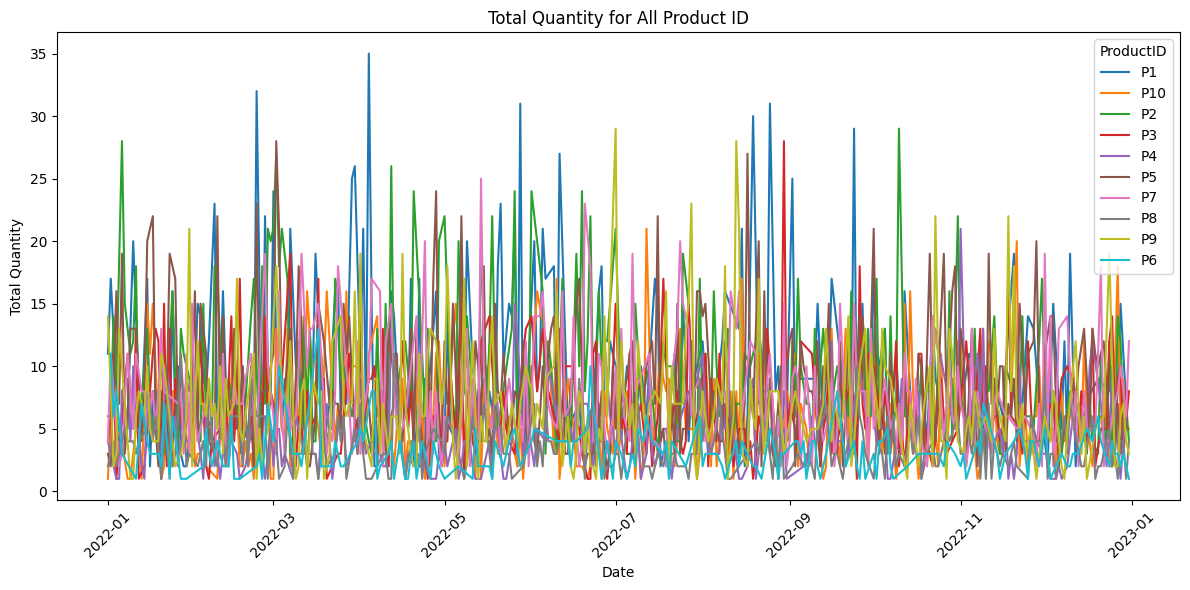

In [203]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', hue='ProductID', data=df, color=color_palette)
plt.title(f'Total Quantity for All Product ID')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

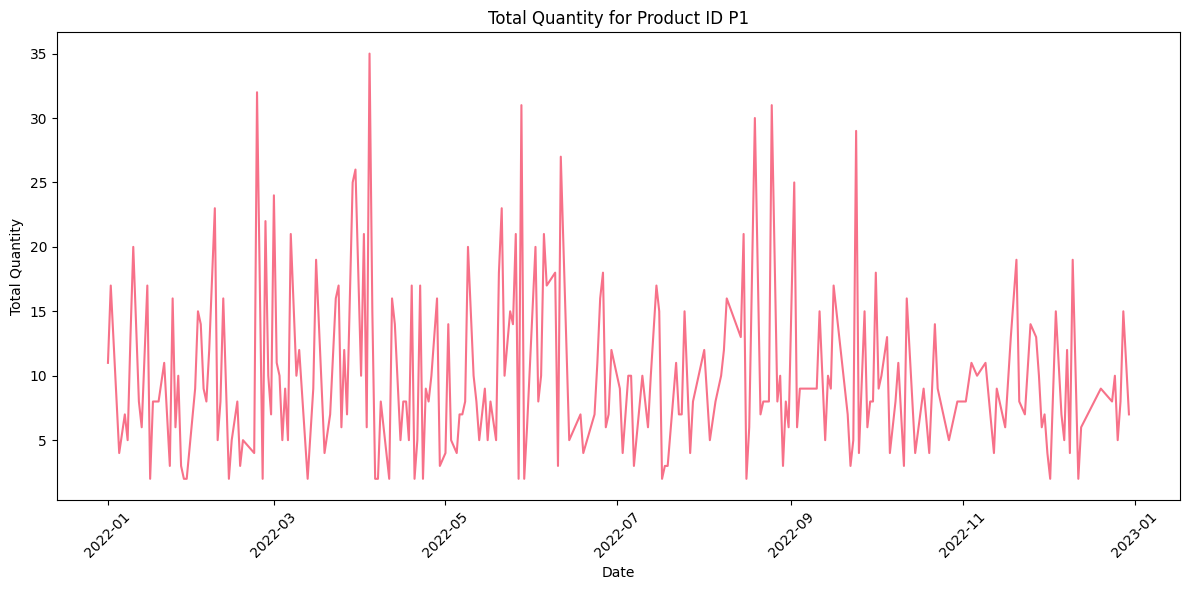

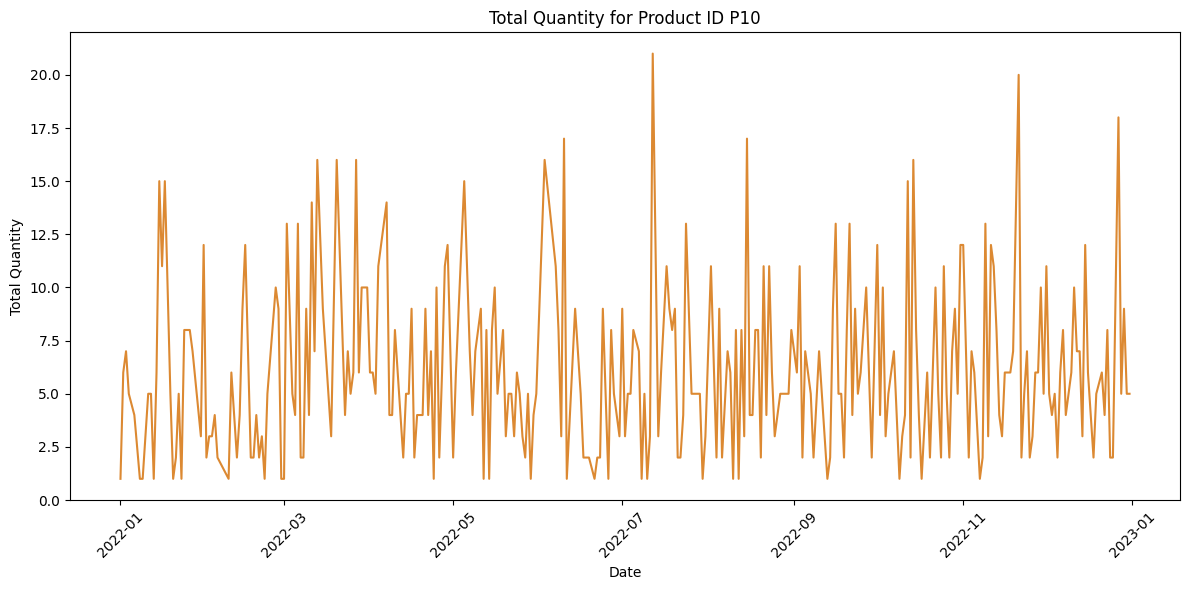

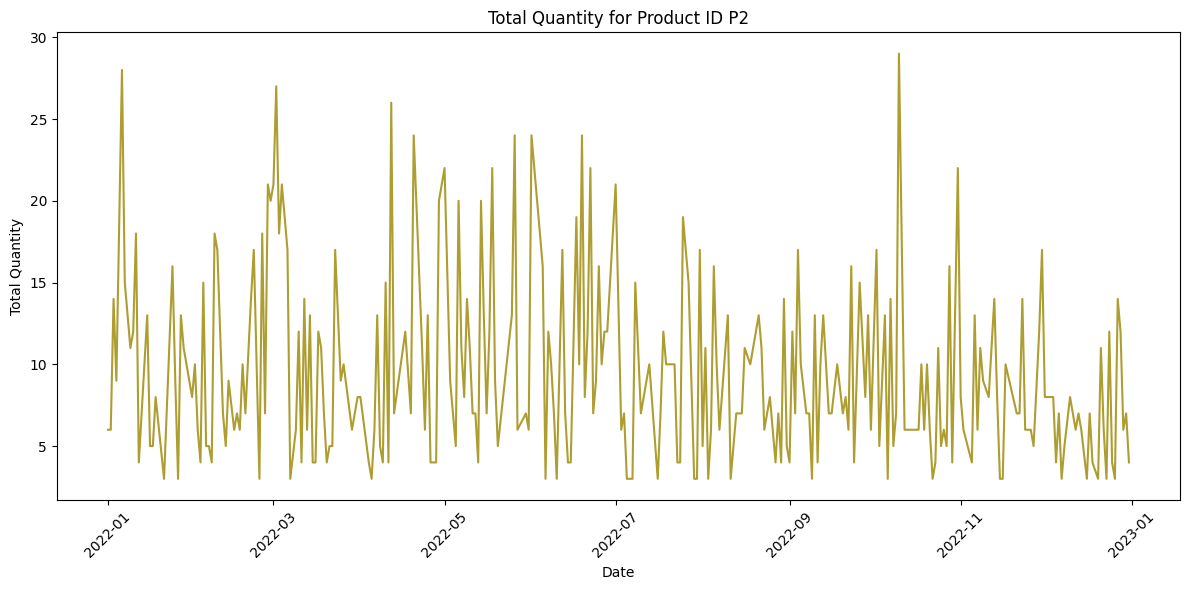

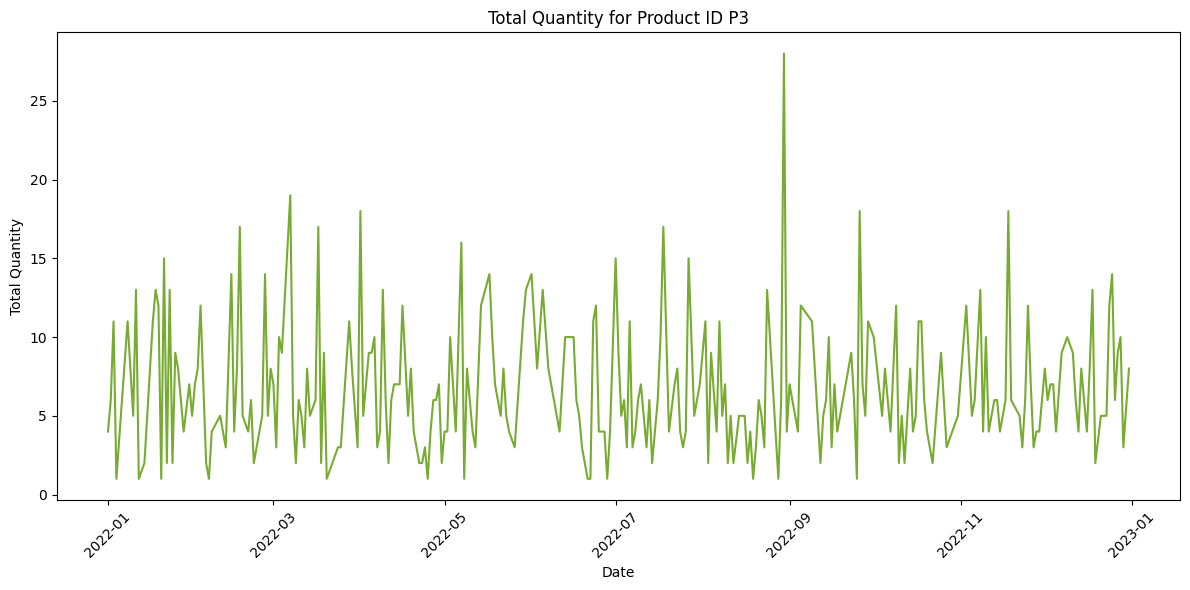

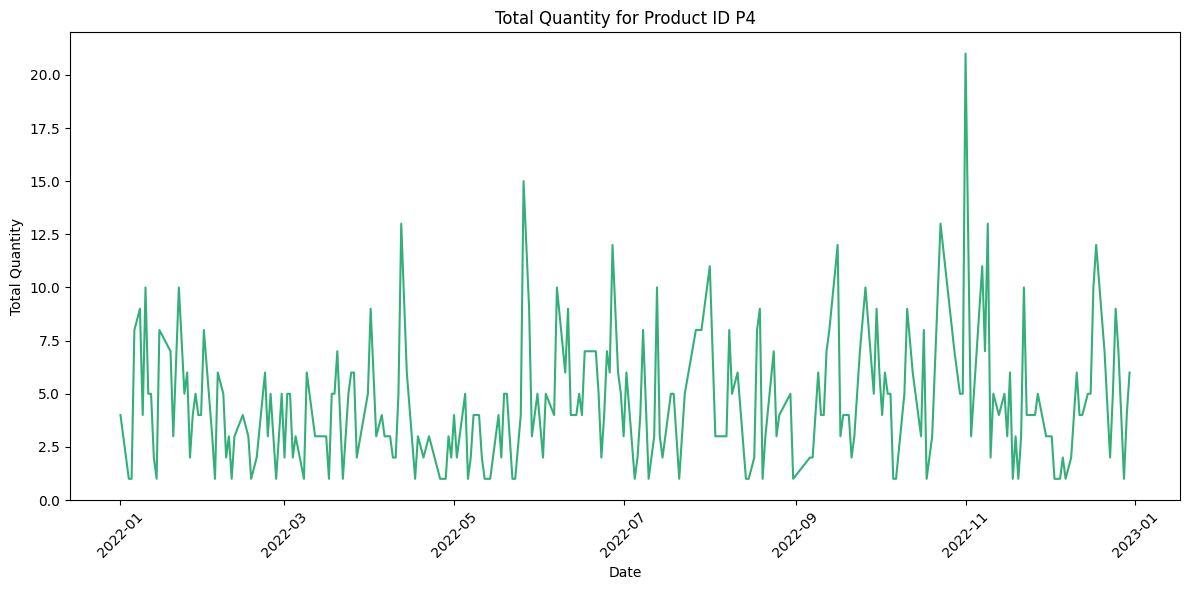

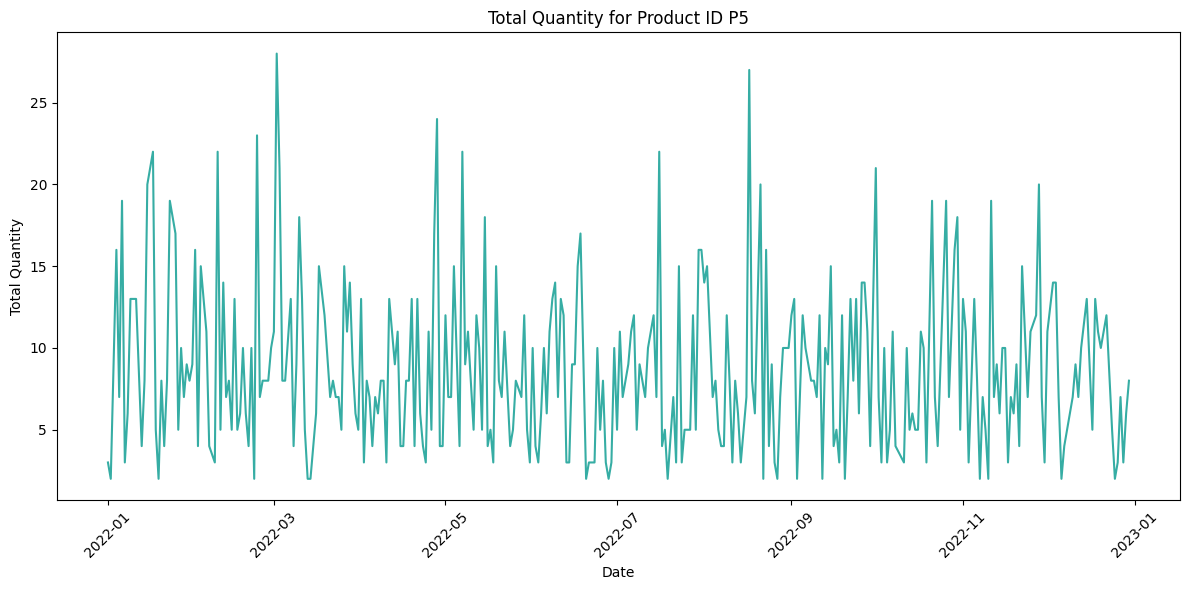

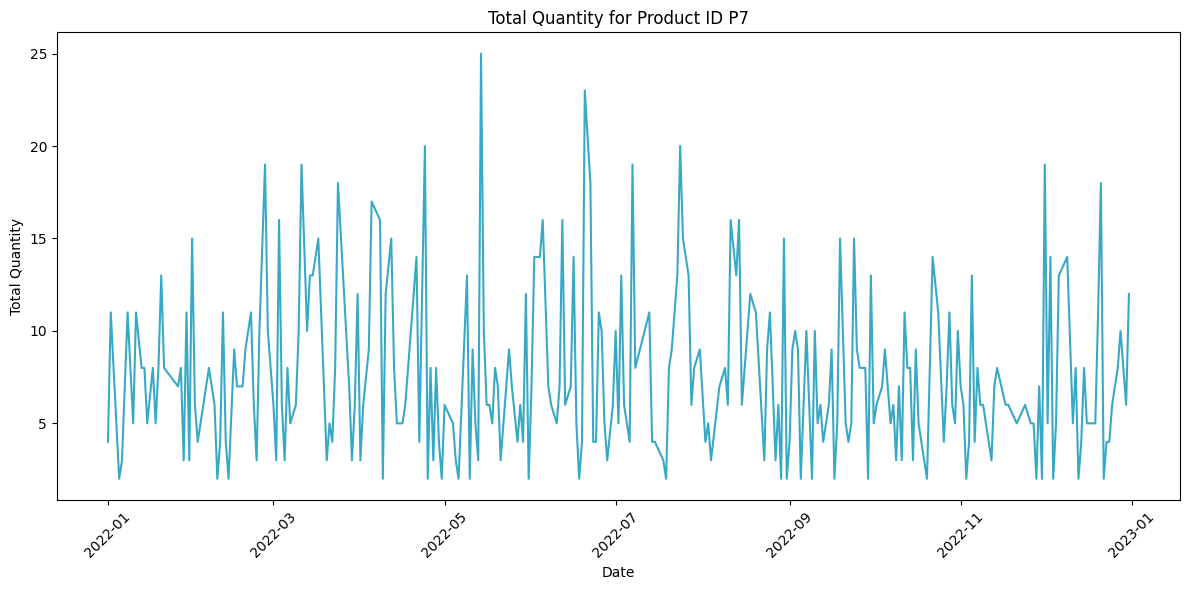

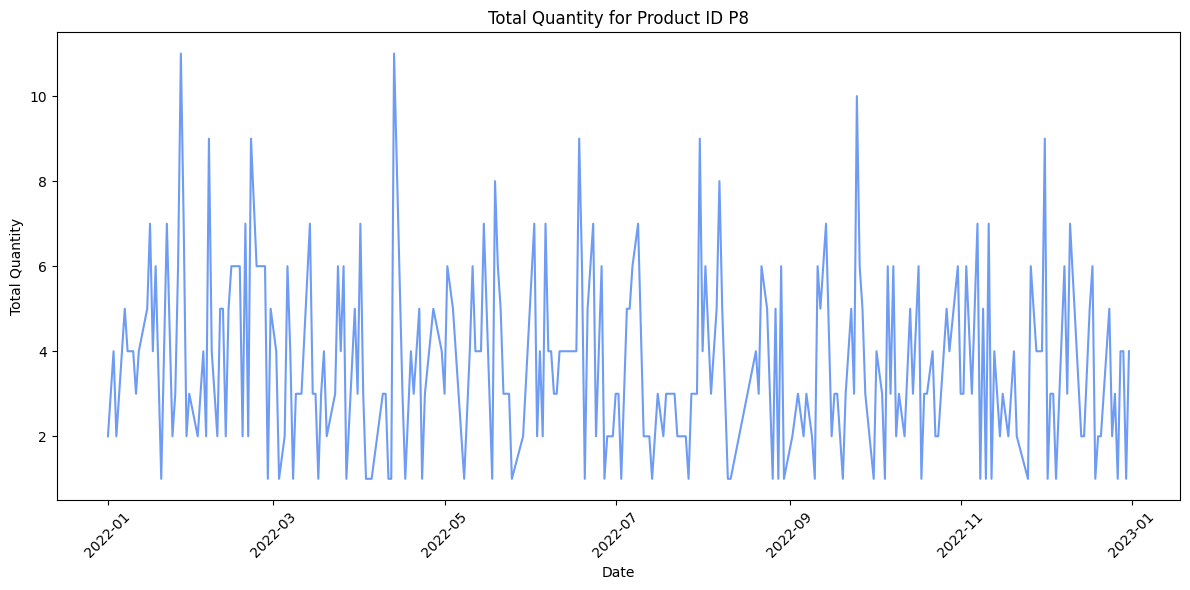

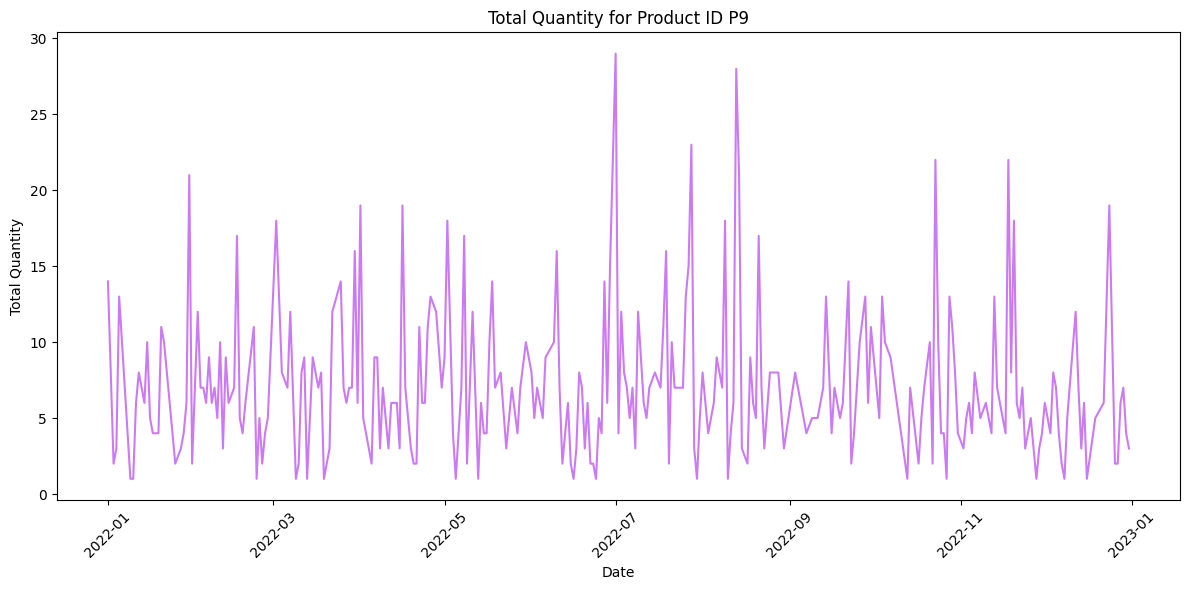

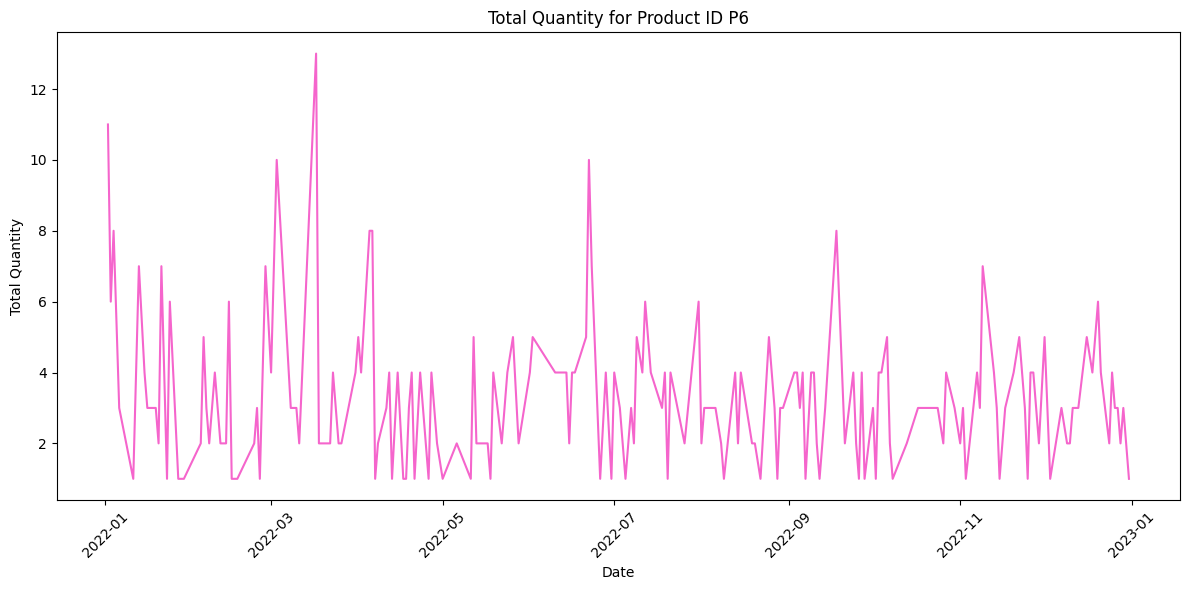

In [204]:
# Membuat plot terpisah untuk setiap product ID dengan warna yang berbeda
for idx, product_id in enumerate(product_ids):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y='Qty', data=df[df['ProductID'] == product_id], color=color_palette[idx])
    plt.title(f'Total Quantity for Product ID {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [205]:
df

,Date,ProductID,Qty
0,2022-01-01,P1,11
1,2022-01-01,P10,1
2,2022-01-01,P2,6
3,2022-01-01,P3,4
4,2022-01-01,P4,4
...,...,...,...
2661,2022-12-31,P3,8
2662,2022-12-31,P6,1
2663,2022-12-31,P7,12
2664,2022-12-31,P8,4


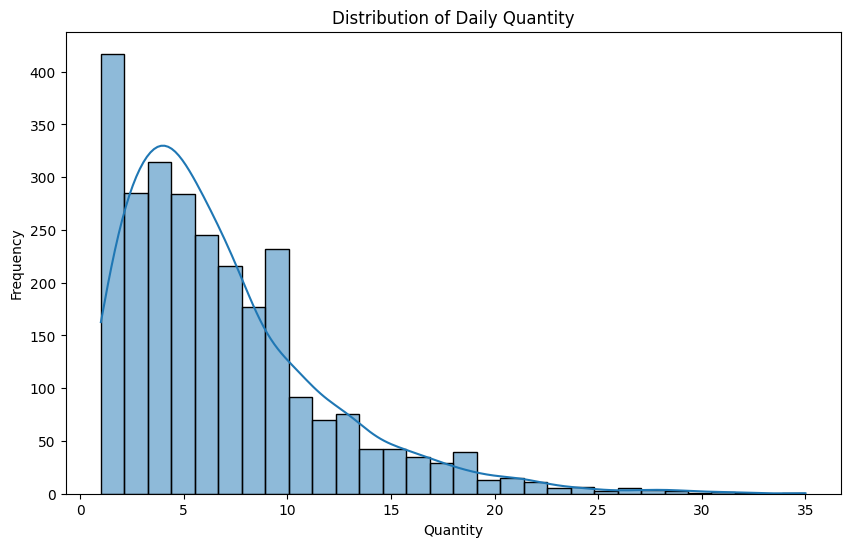

In [206]:
# Distribusi Jumlah Quantity
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Qty', bins=30, kde=True)
plt.title('Distribution of Daily Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

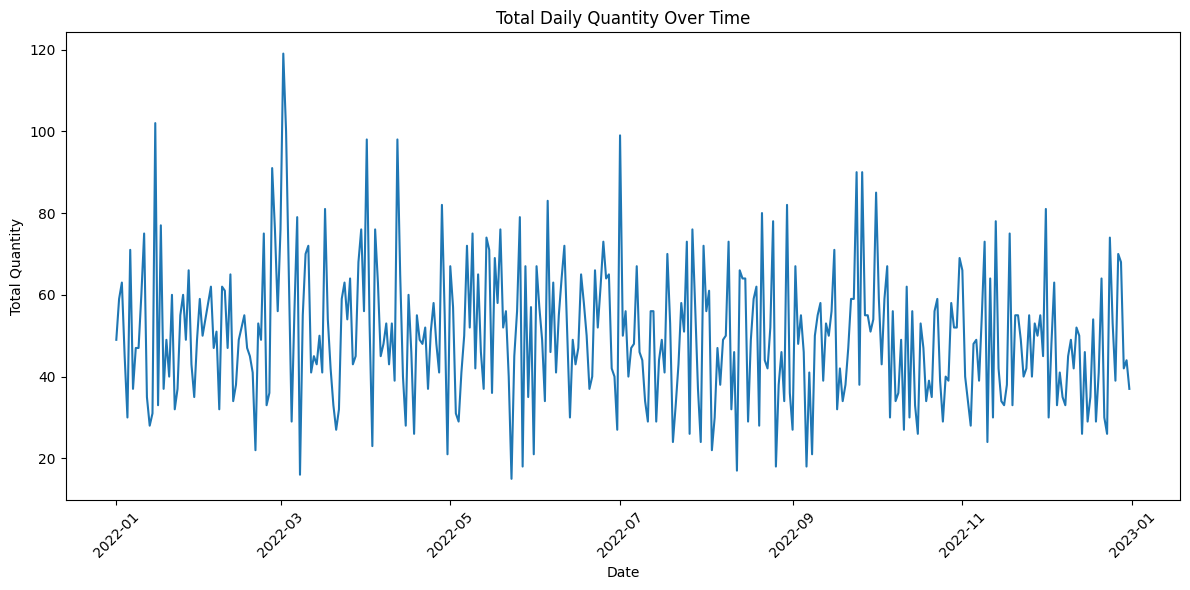

In [207]:
# Tren Waktu
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', data=df.groupby('Date')['Qty'].sum().reset_index())
plt.title('Total Daily Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

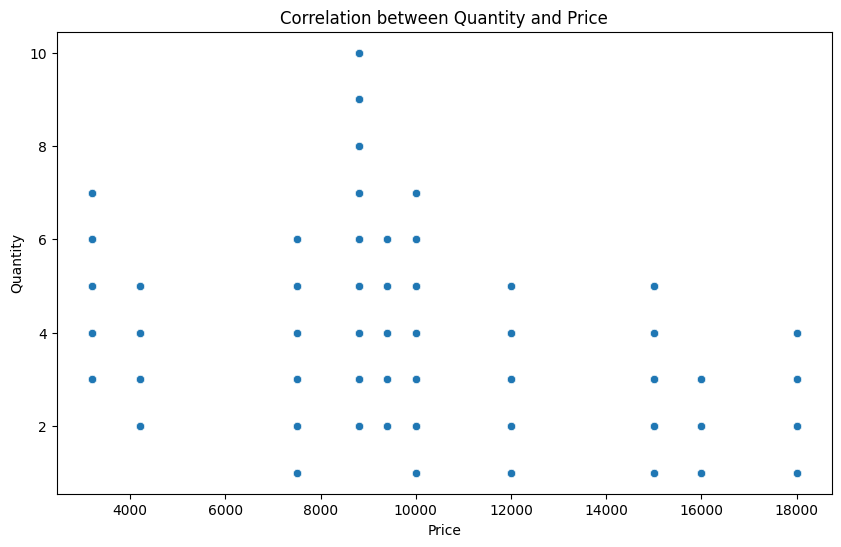

In [208]:
# Korelasi antara Quantity dengan Harga
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price_x', y='Qty', data=df_merge)
plt.title('Correlation between Quantity and Price')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.show()

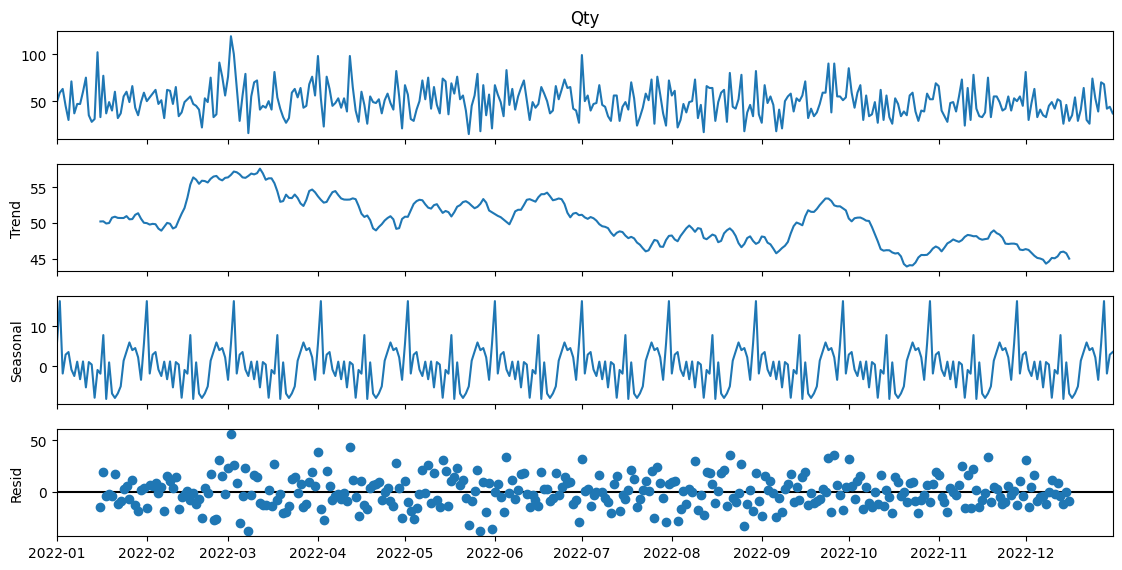

In [209]:
# Decompose Time Series
decomposition = seasonal_decompose(df.groupby('Date')['Qty'].sum(), period=30)  # Misalnya, periode musiman 30 hari
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Data Preparation

In [210]:
# Menghitung total quantity berdasarkan tanggal dan product_id
grouped_data = df.groupby(['Date', 'ProductID'])['Qty'].sum().reset_index()
grouped_data

,Date,ProductID,Qty
0,2022-01-01,P1,11
1,2022-01-01,P10,1
2,2022-01-01,P2,6
3,2022-01-01,P3,4
4,2022-01-01,P4,4
...,...,...,...
2661,2022-12-31,P3,8
2662,2022-12-31,P6,1
2663,2022-12-31,P7,12
2664,2022-12-31,P8,4


In [211]:
# Membuat data frame baru untuk time series dengan product_id sebagai kolom
time_series_df = grouped_data.pivot(index='Date', columns='ProductID', values='Qty').fillna(0)
time_series_df.sort_index()
time_series_df.head()

ProductID,P1,P10,P2,P3,P4,P5,P6,P7,P8,P9
Date,,,,,,,,,,
2022-01-01,11.0,1.0,6.0,4.0,4.0,3.0,0.0,4.0,2.0,14.0
2022-01-02,17.0,6.0,6.0,6.0,0.0,2.0,11.0,11.0,0.0,0.0
2022-01-03,0.0,7.0,14.0,11.0,2.0,9.0,6.0,8.0,4.0,2.0
2022-01-04,0.0,5.0,9.0,1.0,1.0,16.0,8.0,0.0,2.0,3.0
2022-01-05,4.0,0.0,0.0,0.0,1.0,7.0,0.0,2.0,3.0,13.0


In [212]:
# Pisahkan data untuk pelatihan dan pengujian
train_size = int(0.9 * len(time_series_df))
train_data = time_series_df[:train_size]
test_data = time_series_df[train_size:]

In [213]:
# # Inisialisasi scaler
# scaler = MinMaxScaler()

# # Normalisasi data
# df_normalized = scaler.fit_transform(time_series_df)
# train_data_normalized = scaler.transform(train_data)
# test_data_normalized = scaler.transform(test_data)

# # Konversi kembali ke DataFrame setelah normalisasi
# df_normalized = pd.DataFrame(df_normalized, columns=time_series_df.columns, index=time_series_df.index)
# train_data_normalized = pd.DataFrame(train_data_normalized, columns=train_data.columns, index=train_data.index)
# test_data_normalized = pd.DataFrame(test_data_normalized, columns=test_data.columns, index=test_data.index)

## Modeling

In [214]:
# Daftar product_id
product_ids = time_series_df.columns[0:]  # Mengambil kolom kecuali tanggal

# Dictionary untuk menyimpan hasil model dan prediksi
models = {}
predictions = {}


In [ ]:
# orders = {
#     'P6' : (7, 2, 7)
# }

In [285]:
# Loop melalui setiap product_id
for product_id in product_ids:
    print(f"Training model for Product ID: {product_id}")
    
    # Pilih data untuk product_id tertentu
    train_data_id = train_data[product_id]
    
    # Order Determination
    # ... (gunakan metode ACF, PACF, atau yang lainnya untuk menentukan p, d, q)

    # Inisialisasi model ARIMA
    p, d, q = 1, 1, 1 # Ganti dengan nilai yang sesuai analisis data yang telah dilakukan
    model = ARIMA(train_data_id, order=(p, d, q))

    # Latih model SARIMAX
    model_fit = model.fit()
    models[product_id] = model_fit

Training model for Product ID: P1
Training model for Product ID: P7


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Training model for Product ID: P5
Training model for Product ID: P9


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Training model for Product ID: P3
Training model for Product ID: P2


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Training model for Product ID: P10
Training model for Product ID: P4


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Training model for Product ID: P8
Training model for Product ID: P6


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

## Evaluation

In [286]:
# Dictionary untuk menyimpan hasil mse
results = {}

Mean Squared Error for Product ID P1: 29.139760065109495


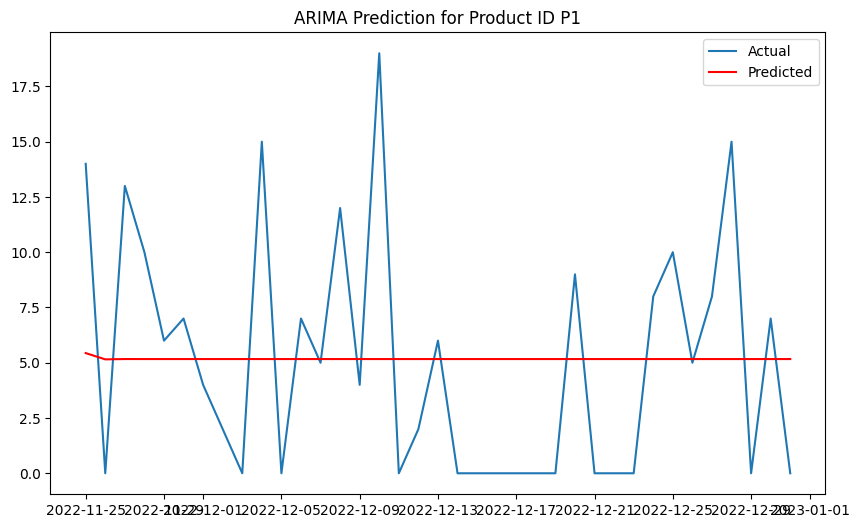

Mean Squared Error for Product ID P7: 25.19857649612977


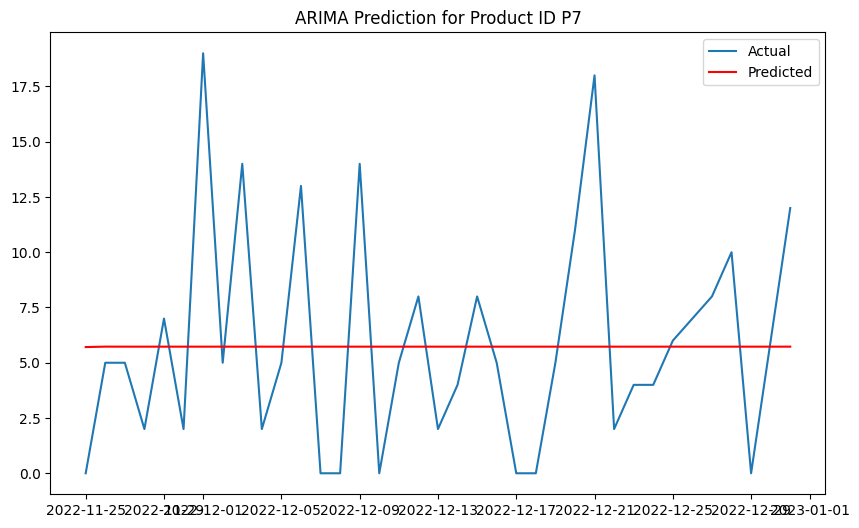

Mean Squared Error for Product ID P5: 26.307889756430043


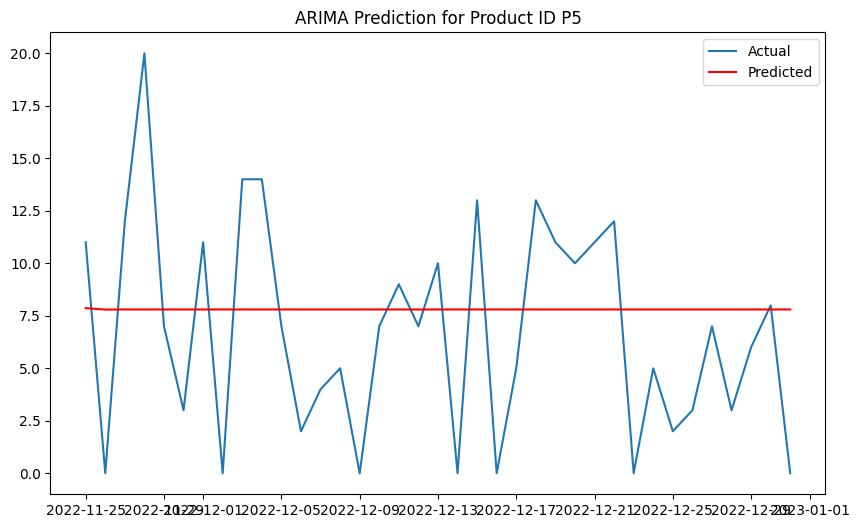

Mean Squared Error for Product ID P9: 18.330145104934502


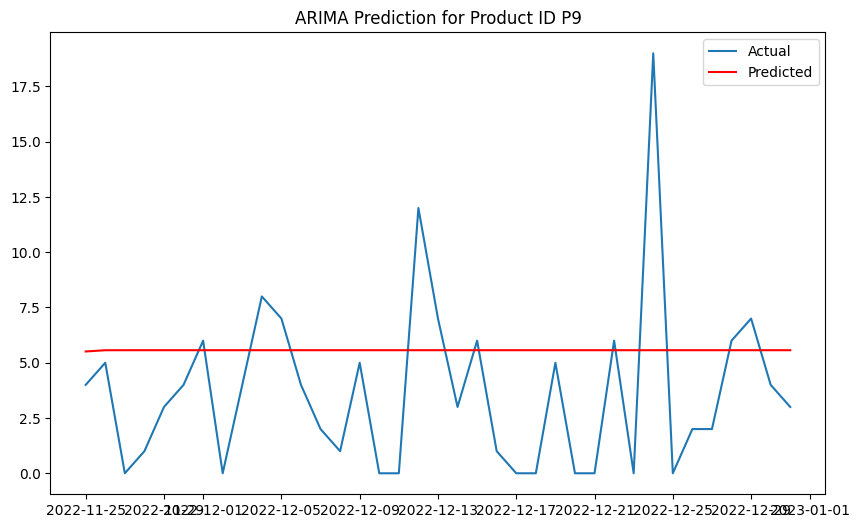

Mean Squared Error for Product ID P3: 16.9286335681144


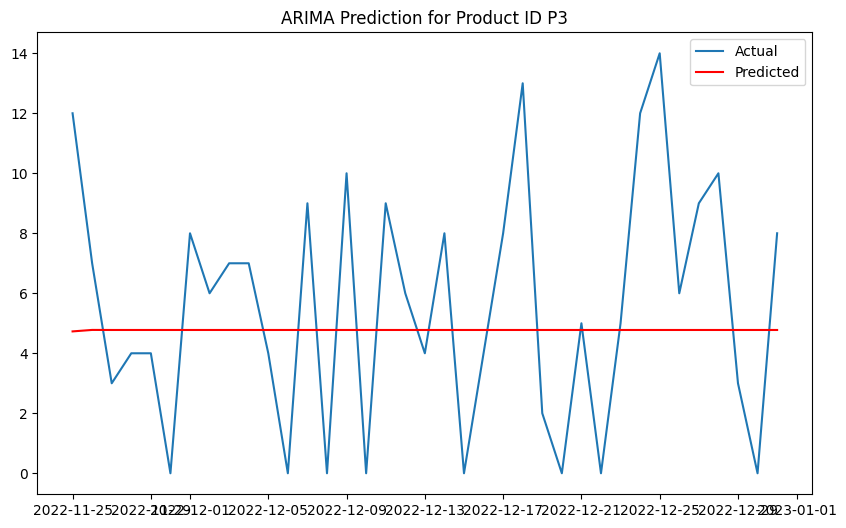

Mean Squared Error for Product ID P2: 18.099115630088424


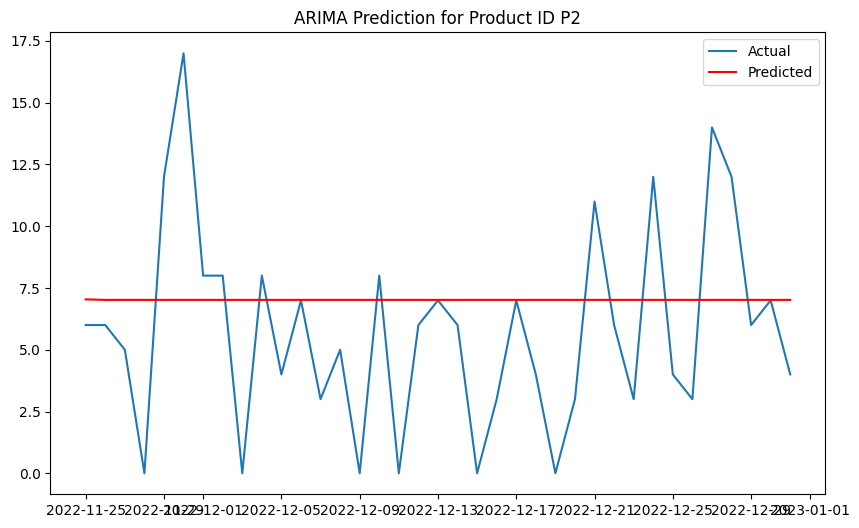

Mean Squared Error for Product ID P10: 12.798870851994305


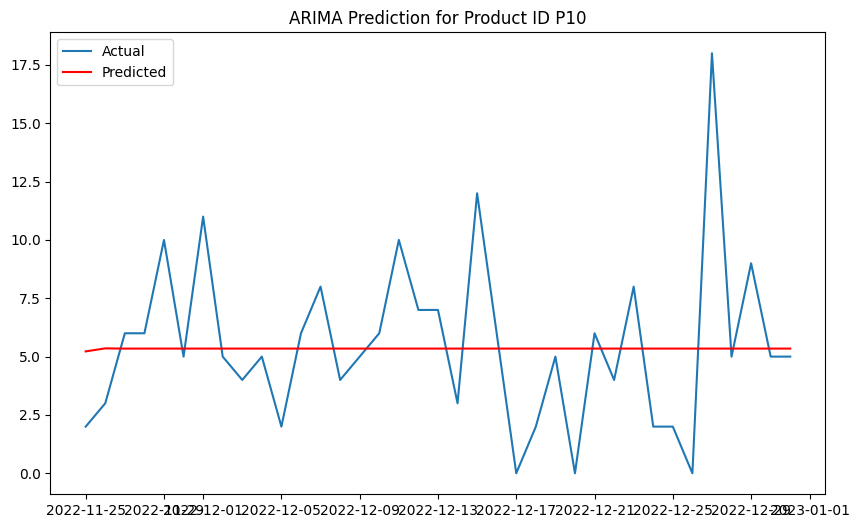

Mean Squared Error for Product ID P4: 9.827788622780565


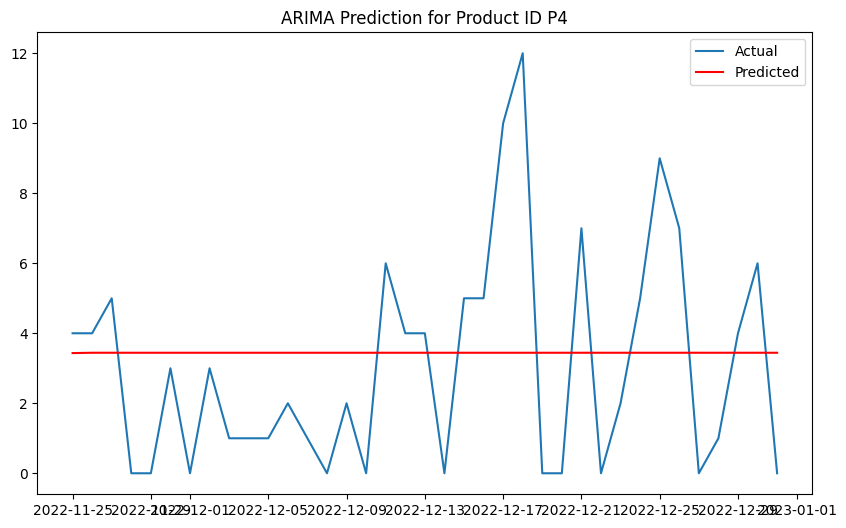

Mean Squared Error for Product ID P8: 5.198055803766775


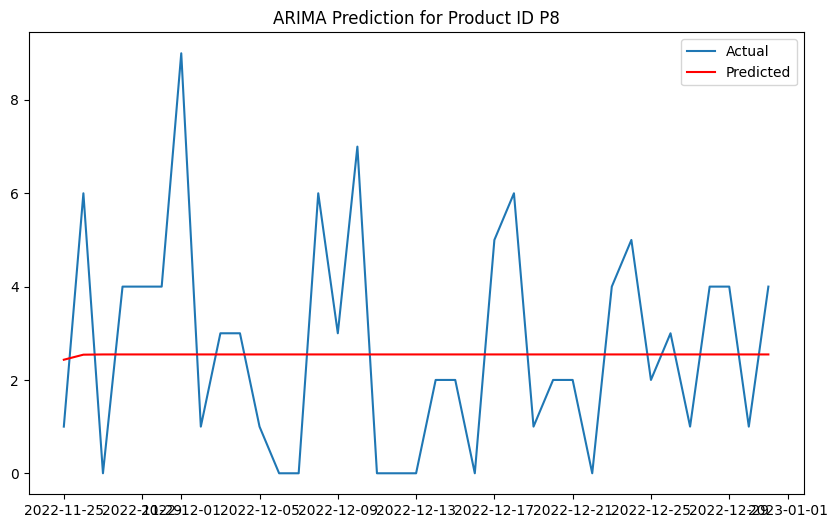

Mean Squared Error for Product ID P6: 3.207579095696079


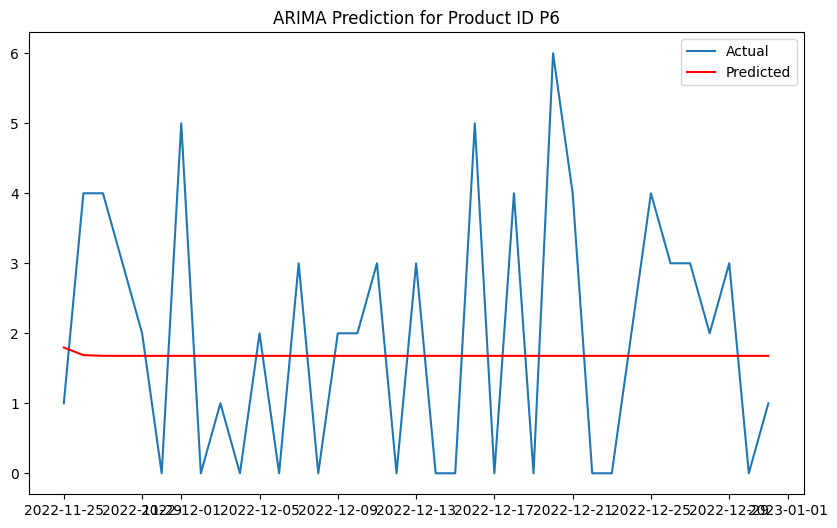

In [287]:
# Loop melalui setiap product_id
for product_id in product_ids:
    # Pilih data untuk product_id tertentu
    test_data_id = test_data[product_id]
    
    # Lakukan prediksi pada data uji
    predictions[product_id] = models[product_id].get_forecast(steps=len(test_data_id)).predicted_mean

    # Mengembalikan data yang dinormalisasi ke skala semula
    # predictions_actual = scaler.inverse_transform(predictions[product_id].values.reshape(-1, 1))
    # test_actual = scaler.inverse_transform(test_data.values.reshape(-1, 1))
    prediction_id = predictions[product_id]
    
    # Hitung Mean Squared Error
    mse = mean_squared_error(test_data_id, prediction_id)
    results[product_id] = mse
    print(f"Mean Squared Error for Product ID {product_id}: {mse}")

    # Plot hasil prediksi
    plt.figure(figsize=(10, 6))
    plt.plot(test_data_id, label='Actual')
    plt.plot(prediction_id, color='red', label='Predicted')
    plt.legend()
    plt.title(f'ARIMA Prediction for Product ID {product_id}')
    plt.show()

In [288]:
# Convert dictionary to list of tuples for sorting
sorted_mse_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

# Separate product_ids and MSE values
product_ids, mse_values = zip(*sorted_mse_results)


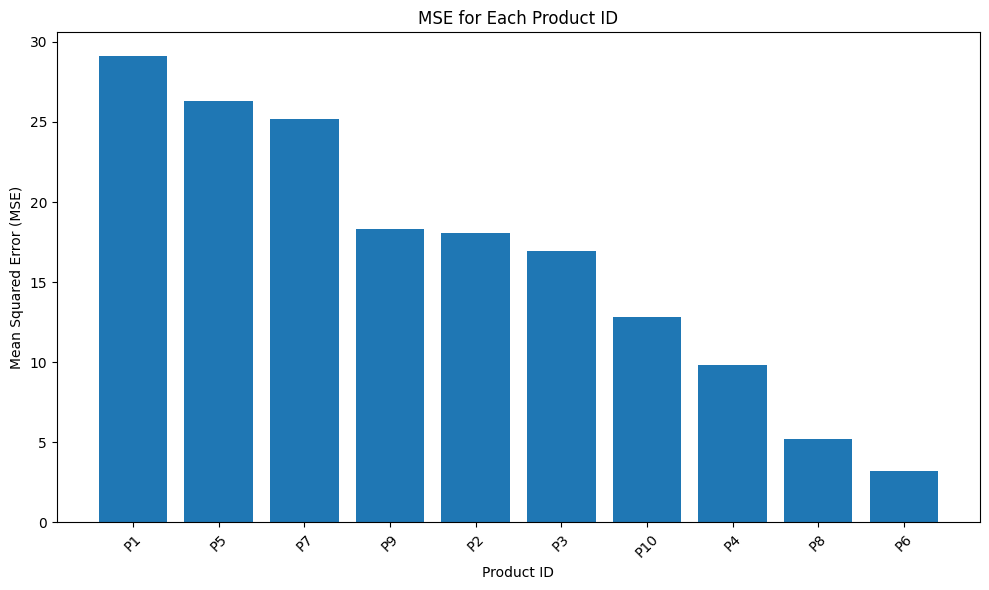

In [289]:
# Menampilkan grafik dari MSE untuk setiap product
plt.figure(figsize=(10, 6))
plt.bar(product_ids, mse_values)
plt.xlabel('Product ID')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Product ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [290]:
sorted_mse_results

[('P1', 29.139760065109495),
 ('P5', 26.307889756430043),
 ('P7', 25.19857649612977),
 ('P9', 18.330145104934502),
 ('P2', 18.099115630088424),
 ('P3', 16.9286335681144),
 ('P10', 12.798870851994305),
 ('P4', 9.827788622780565),
 ('P8', 5.198055803766775),
 ('P6', 3.207579095696079)]